In [1]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

In [2]:
#load data
data = pd.read_csv(r"D:\python for data science\notebooks\heart_cleveland_upload.csv")
data.describe()
data.info()
print(data.isnull().sum())
data.columns


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
conditio

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')

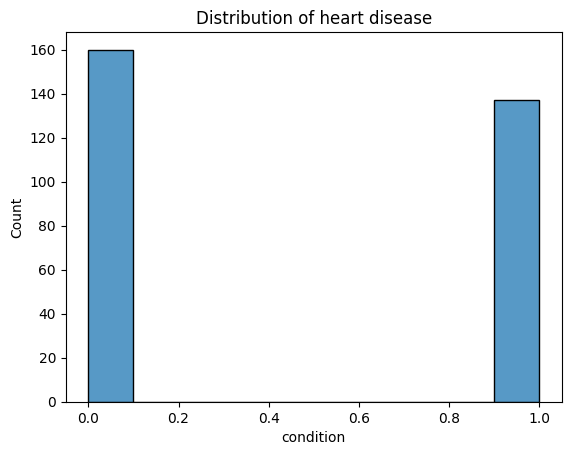

In [3]:
#Data Visualization
plt.Figure(figsize=(1000,500))
sns.histplot(data=data , x="condition")
plt.title("Distribution of heart disease")
plt.show()


In [4]:
#Modeling
x=data.drop(["condition"] , axis=1)
y=data["condition"]
x_train , x_test , y_train , y_test =model_selection.train_test_split(x ,y , test_size=0.2,random_state=42 , stratify=y)
x_train , y_train , x_test , y_test


modeles={"RandomForestClassifier":RandomForestClassifier() , 
         "GradientBoostingClassifier":GradientBoostingClassifier() ,
         "LogisticRegression" :LogisticRegression()}

for name,x in modeles.items():
    x.fit(x_train,y_train)
    y_pre=x.predict(x_train)
    score=r2_score(y_train,y_pre)
    accuracy=accuracy_score(y_train, y_pre)
    print(f"{name} r2 score (train) is:{score:0.4f} and accuracy score is {accuracy} ")

best_model=RandomForestClassifier()
best_model.fit(x_train,y_train)
y_pre=best_model.predict(x_test)



RandomForestClassifier r2 score (train) is:1.0000 and accuracy score is 1.0 
GradientBoostingClassifier r2 score (train) is:0.9830 and accuracy score is 0.9957805907172996 
LogisticRegression r2 score (train) is:0.3885 and accuracy score is 0.8481012658227848 


d:\python for data science\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [5]:
import pickle
import streamlit as st
filename="heart_disease.sav"
pickle.dump(best_model,open(filename,'wb'))